# Change point detaction by knots estimation

In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import bernoulli

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sandwich_kernel(x, x_i):
    """
    x: points required to compute kernel weight
    x_i: reference points location used to compute correspondent distance of each entry points
    return:
        a matrix with N x M such that
        N as the number of entry points
        M as the number of reference points
        matrix entries hold the value of weight of each element
    see also:
      1. https://mc-stan.org/docs/2_24/stan-users-guide/gaussian-process-regression.html
      2. https://en.wikipedia.org/wiki/Local_regression
    """
    N = len(x)
    M = len(x_i)
    k = np.zeros((N, M), dtype=np.double)

    np_idx = np.where(x < x_i[0])
    k[np_idx, 0] = 1

    for m in range(M - 1):
        np_idx = np.where(np.logical_and(x >= x_i[m], x < x_i[m + 1]))
        total_dist = x_i[m + 1] - x_i[m]
        backward_dist = x[np_idx] - x_i[m]
        forward_dist = x_i[m + 1] - x[np_idx]
        k[np_idx, m] = forward_dist / total_dist
        k[np_idx, m + 1] = backward_dist / total_dist

    np_idx = np.where(x >= x_i[M - 1])
    k[np_idx, M - 1] = 1

    # TODO: it is probably not needed
    k = k / np.sum(k, axis=1, keepdims=True)

    return k

In [3]:
T = 365 * 3
N_KNOTS = 60
np.random.seed(2021)

In [4]:
noise = np.random.normal(0, 1, T)

In [5]:
is_jump = (np.random.uniform(0, 1, N_KNOTS) > 0.9).astype(np.int32)
is_jump

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0], dtype=int32)

In [6]:
jump_size = np.random.normal(0, 2, N_KNOTS) 

In [7]:
knots = np.cumsum(is_jump * jump_size)

In [8]:
# normalize time
width = 1/len(knots)
tp = np.arange(1, T + 1)/ T
knots_tp = np.arange(width/2, 1, width)

In [9]:
K = sandwich_kernel(tp, knots_tp)

In [10]:
print(K.shape, knots.shape)

(1095, 60) (60,)


In [11]:
trend = np.matmul(K, knots) + noise

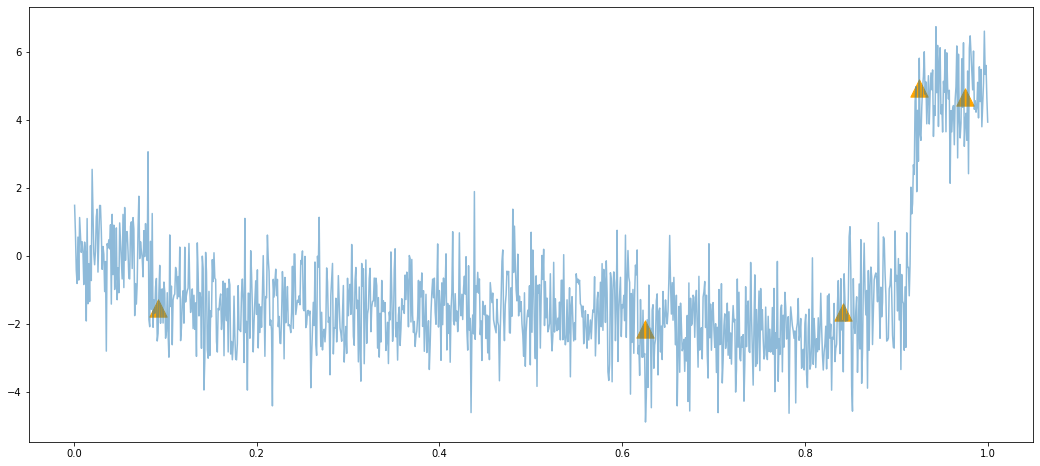

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, trend, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='orange');

Question here: can we create a pyro to connect the knots?